In [10]:
# autoreload
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import torch
from transformers import AutoModel, AutoTokenizer
from copy import deepcopy
from graphs.llama_graph import TransformerEncoderGraph


In [12]:
# this is a model
model_name = "HuggingFaceTB/SmolLM-135M-Instruct"
# not used yet
# tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

print(model)

# defaults merge the minimum so we need to add flags or change defaults
# example = qk=True, merge_type='all', classifier=??
#graph1 = TransformerEncoderGraph(deepcopy(model)).graphify()

LlamaModel(
  (embed_tokens): Embedding(49152, 576, padding_idx=2)
  (layers): ModuleList(
    (0-29): 30 x LlamaDecoderLayer(
      (self_attn): LlamaSdpaAttention(
        (q_proj): Linear(in_features=576, out_features=576, bias=False)
        (k_proj): Linear(in_features=576, out_features=192, bias=False)
        (v_proj): Linear(in_features=576, out_features=192, bias=False)
        (o_proj): Linear(in_features=576, out_features=576, bias=False)
        (rotary_emb): LlamaRotaryEmbedding()
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
        (up_proj): Linear(in_features=576, out_features=1536, bias=False)
        (down_proj): Linear(in_features=1536, out_features=576, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
    )
  )
  (norm): LlamaRMSNorm((576,), eps=1e-05)
  (rotary_emb): LlamaRotaryEmbedding

In [22]:
model.config.head_dim

64

In [23]:
model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "HuggingFaceTB/SmolLM-135M-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 576,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 9,
  "num_hidden_layers": 30,
  "num_key_value_heads": 3,
  "pad_token_id": 2,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.47.0",
  "use_cache": true,
  "vocab_size": 49152
}

In [13]:
for i, (name, module) in enumerate(model.named_modules()):
    print(name)
    print(module)
    print("---")
    break


LlamaModel(
  (embed_tokens): Embedding(49152, 576, padding_idx=2)
  (layers): ModuleList(
    (0-29): 30 x LlamaDecoderLayer(
      (self_attn): LlamaSdpaAttention(
        (q_proj): Linear(in_features=576, out_features=576, bias=False)
        (k_proj): Linear(in_features=576, out_features=192, bias=False)
        (v_proj): Linear(in_features=576, out_features=192, bias=False)
        (o_proj): Linear(in_features=576, out_features=576, bias=False)
        (rotary_emb): LlamaRotaryEmbedding()
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
        (up_proj): Linear(in_features=576, out_features=1536, bias=False)
        (down_proj): Linear(in_features=1536, out_features=576, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
    )
  )
  (norm): LlamaRMSNorm((576,), eps=1e-05)
  (rotary_emb): LlamaRotaryEmbeddin

In [9]:
module.embed_tokens

Embedding(49152, 576, padding_idx=2)

In [17]:
module.layers[0].self_attn.q_proj.weight.shape

torch.Size([576, 576])

In [18]:
module.layers[0].self_attn.k_proj.weight.shape

torch.Size([192, 576])

In [19]:
module.layers[0].self_attn.v_proj.weight.shape

torch.Size([192, 576])

In [4]:
llama_modules = {"emb": "embed_tokens",
                 "emb_ln": "input_layernorm",
                 "q": "self_attn.q_proj",
                 "k": "self_attn.k_proj",
                 "v": "self_attn.v_proj",
                 'attn_o': 'self_attn.o_proj',
                 'post_attn_norm': 'post_attention_layernorm',
                 'silu': 'mlp.act_fn',
                 'up_proj': 'mlp.up_proj',
                 'gate_proj': 'mlp.gate_proj',
                 'down_proj': 'mlp.down_proj',
                 'final_norm': 'norm'}
# todo: add output proj and rotary embeddings
# todo: missing final rms norm
graph1 = TransformerEncoderGraph(deepcopy(model), modules=llama_modules, num_layers=30)
graph1 = graph1.graphify()

In [5]:
base_model_name = "HuggingFaceTB/SmolLM-135M"
# not used yet
# tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(base_model_name)
base_model.eval()

graph2 = TransformerEncoderGraph(deepcopy(base_model), modules=llama_modules, num_layers=30)
graph2 = graph2.graphify()

In [6]:
from model_merger import ModelMerge

merge = ModelMerge(graph1, graph2, device="cpu")


0
1


In [7]:
from matching_functions import match_tensors_permute
from torch.utils.data import TensorDataset, DataLoader

input_ids = torch.randint(0, 100, (5, 10))
lens = torch.tensor([10]*5).unsqueeze(1)
dataloader = DataLoader(TensorDataset(input_ids, lens), batch_size=1)

model3 = AutoModel.from_pretrained(model_name)
model3.eval()


LlamaModel(
  (embed_tokens): Embedding(49152, 576, padding_idx=2)
  (layers): ModuleList(
    (0-29): 30 x LlamaDecoderLayer(
      (self_attn): LlamaSdpaAttention(
        (q_proj): Linear(in_features=576, out_features=576, bias=False)
        (k_proj): Linear(in_features=576, out_features=192, bias=False)
        (v_proj): Linear(in_features=576, out_features=192, bias=False)
        (o_proj): Linear(in_features=576, out_features=576, bias=False)
        (rotary_emb): LlamaRotaryEmbedding()
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
        (up_proj): Linear(in_features=576, out_features=1536, bias=False)
        (down_proj): Linear(in_features=1536, out_features=576, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
    )
  )
  (norm): LlamaRMSNorm((576,), eps=1e-05)
  (rotary_emb): LlamaRotaryEmbedding

In [8]:
merge.transform(model3, dataloader, transform_fn=match_tensors_permute)


Forward Pass to Compute Merge Metrics:   0%|          | 0/5 [00:00<?, ?it/s]

/home/daniter/code/pretrain_merge/merging-text-transformers/graphs/base_graph.py:319: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
/home/daniter/miniconda3/envs/research/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Intermediate keys
dict_keys([3, 9, 7, 5, 12, 16, 20, 18, 24, 27, 33, 31, 29, 36, 40, 44, 42, 48, 51, 57, 55, 53, 60, 64, 68, 66, 72, 75, 81, 79, 77, 84, 88, 92, 90, 96, 99, 105, 103, 101, 108, 112, 116, 114, 120, 123, 129, 127, 125, 132, 136, 140, 138, 144, 147, 153, 151, 149, 156, 160, 164, 162, 168, 171, 177, 175, 173, 180, 184, 188, 186, 192, 195, 201, 199, 197, 204, 208, 212, 210, 216, 219, 225, 223, 221, 228, 232, 236, 234, 240, 243, 249, 247, 245, 252, 256, 260, 258, 264, 267, 273, 271, 269, 276, 280, 284, 282, 288, 291, 297, 295, 293, 300, 304, 308, 306, 312, 315, 321, 319, 317, 324, 328, 332, 330, 336, 339, 345, 343, 341, 348, 352, 356, 354, 360, 363, 369, 367, 365, 372, 376, 380, 378, 384, 387, 393, 391, 389, 396, 400, 404, 402, 408, 411, 417, 415, 413, 420, 424, 428, 426, 432, 435, 441, 439, 437, 444, 448, 452, 450, 456, 459, 465, 463, 461, 468, 472, 476, 474, 480, 483, 489, 487, 485, 492, 496, 500, 498, 504, 507, 513, 511, 509, 516, 520, 524, 522, 528, 531, 537, 535, 533, 54

Forward Pass to Compute Merge Metrics:  20%|██        | 1/5 [00:05<00:20,  5.24s/it]

Intermediate keys
dict_keys([3, 9, 7, 5, 12, 16, 20, 18, 24, 27, 33, 31, 29, 36, 40, 44, 42, 48, 51, 57, 55, 53, 60, 64, 68, 66, 72, 75, 81, 79, 77, 84, 88, 92, 90, 96, 99, 105, 103, 101, 108, 112, 116, 114, 120, 123, 129, 127, 125, 132, 136, 140, 138, 144, 147, 153, 151, 149, 156, 160, 164, 162, 168, 171, 177, 175, 173, 180, 184, 188, 186, 192, 195, 201, 199, 197, 204, 208, 212, 210, 216, 219, 225, 223, 221, 228, 232, 236, 234, 240, 243, 249, 247, 245, 252, 256, 260, 258, 264, 267, 273, 271, 269, 276, 280, 284, 282, 288, 291, 297, 295, 293, 300, 304, 308, 306, 312, 315, 321, 319, 317, 324, 328, 332, 330, 336, 339, 345, 343, 341, 348, 352, 356, 354, 360, 363, 369, 367, 365, 372, 376, 380, 378, 384, 387, 393, 391, 389, 396, 400, 404, 402, 408, 411, 417, 415, 413, 420, 424, 428, 426, 432, 435, 441, 439, 437, 444, 448, 452, 450, 456, 459, 465, 463, 461, 468, 472, 476, 474, 480, 483, 489, 487, 485, 492, 496, 500, 498, 504, 507, 513, 511, 509, 516, 520, 524, 522, 528, 531, 537, 535, 533, 54

Forward Pass to Compute Merge Metrics:  40%|████      | 2/5 [00:07<00:10,  3.66s/it]

Intermediate keys
dict_keys([3, 9, 7, 5, 12, 16, 20, 18, 24, 27, 33, 31, 29, 36, 40, 44, 42, 48, 51, 57, 55, 53, 60, 64, 68, 66, 72, 75, 81, 79, 77, 84, 88, 92, 90, 96, 99, 105, 103, 101, 108, 112, 116, 114, 120, 123, 129, 127, 125, 132, 136, 140, 138, 144, 147, 153, 151, 149, 156, 160, 164, 162, 168, 171, 177, 175, 173, 180, 184, 188, 186, 192, 195, 201, 199, 197, 204, 208, 212, 210, 216, 219, 225, 223, 221, 228, 232, 236, 234, 240, 243, 249, 247, 245, 252, 256, 260, 258, 264, 267, 273, 271, 269, 276, 280, 284, 282, 288, 291, 297, 295, 293, 300, 304, 308, 306, 312, 315, 321, 319, 317, 324, 328, 332, 330, 336, 339, 345, 343, 341, 348, 352, 356, 354, 360, 363, 369, 367, 365, 372, 376, 380, 378, 384, 387, 393, 391, 389, 396, 400, 404, 402, 408, 411, 417, 415, 413, 420, 424, 428, 426, 432, 435, 441, 439, 437, 444, 448, 452, 450, 456, 459, 465, 463, 461, 468, 472, 476, 474, 480, 483, 489, 487, 485, 492, 496, 500, 498, 504, 507, 513, 511, 509, 516, 520, 524, 522, 528, 531, 537, 535, 533, 54

Forward Pass to Compute Merge Metrics:  60%|██████    | 3/5 [00:10<00:06,  3.16s/it]

Intermediate keys
dict_keys([3, 9, 7, 5, 12, 16, 20, 18, 24, 27, 33, 31, 29, 36, 40, 44, 42, 48, 51, 57, 55, 53, 60, 64, 68, 66, 72, 75, 81, 79, 77, 84, 88, 92, 90, 96, 99, 105, 103, 101, 108, 112, 116, 114, 120, 123, 129, 127, 125, 132, 136, 140, 138, 144, 147, 153, 151, 149, 156, 160, 164, 162, 168, 171, 177, 175, 173, 180, 184, 188, 186, 192, 195, 201, 199, 197, 204, 208, 212, 210, 216, 219, 225, 223, 221, 228, 232, 236, 234, 240, 243, 249, 247, 245, 252, 256, 260, 258, 264, 267, 273, 271, 269, 276, 280, 284, 282, 288, 291, 297, 295, 293, 300, 304, 308, 306, 312, 315, 321, 319, 317, 324, 328, 332, 330, 336, 339, 345, 343, 341, 348, 352, 356, 354, 360, 363, 369, 367, 365, 372, 376, 380, 378, 384, 387, 393, 391, 389, 396, 400, 404, 402, 408, 411, 417, 415, 413, 420, 424, 428, 426, 432, 435, 441, 439, 437, 444, 448, 452, 450, 456, 459, 465, 463, 461, 468, 472, 476, 474, 480, 483, 489, 487, 485, 492, 496, 500, 498, 504, 507, 513, 511, 509, 516, 520, 524, 522, 528, 531, 537, 535, 533, 54

Forward Pass to Compute Merge Metrics:  80%|████████  | 4/5 [00:12<00:02,  2.92s/it]

Intermediate keys
dict_keys([3, 9, 7, 5, 12, 16, 20, 18, 24, 27, 33, 31, 29, 36, 40, 44, 42, 48, 51, 57, 55, 53, 60, 64, 68, 66, 72, 75, 81, 79, 77, 84, 88, 92, 90, 96, 99, 105, 103, 101, 108, 112, 116, 114, 120, 123, 129, 127, 125, 132, 136, 140, 138, 144, 147, 153, 151, 149, 156, 160, 164, 162, 168, 171, 177, 175, 173, 180, 184, 188, 186, 192, 195, 201, 199, 197, 204, 208, 212, 210, 216, 219, 225, 223, 221, 228, 232, 236, 234, 240, 243, 249, 247, 245, 252, 256, 260, 258, 264, 267, 273, 271, 269, 276, 280, 284, 282, 288, 291, 297, 295, 293, 300, 304, 308, 306, 312, 315, 321, 319, 317, 324, 328, 332, 330, 336, 339, 345, 343, 341, 348, 352, 356, 354, 360, 363, 369, 367, 365, 372, 376, 380, 378, 384, 387, 393, 391, 389, 396, 400, 404, 402, 408, 411, 417, 415, 413, 420, 424, 428, 426, 432, 435, 441, 439, 437, 444, 448, 452, 450, 456, 459, 465, 463, 461, 468, 472, 476, 474, 480, 483, 489, 487, 485, 492, 496, 500, 498, 504, 507, 513, 511, 509, 516, 520, 524, 522, 528, 531, 537, 535, 533, 54

Forward Pass to Compute Merge Metrics: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


> /home/daniter/code/pretrain_merge/merging-text-transformers/metric_calculators.py(82)finalize()
     80         if (torch.diagonal(cov) < 0).sum():
     81             pdb.set_trace()
---> 82         return cov
     83 
     84 class MeanMetric(MetricCalculator):



In [ ]:
# todo: review intermediates

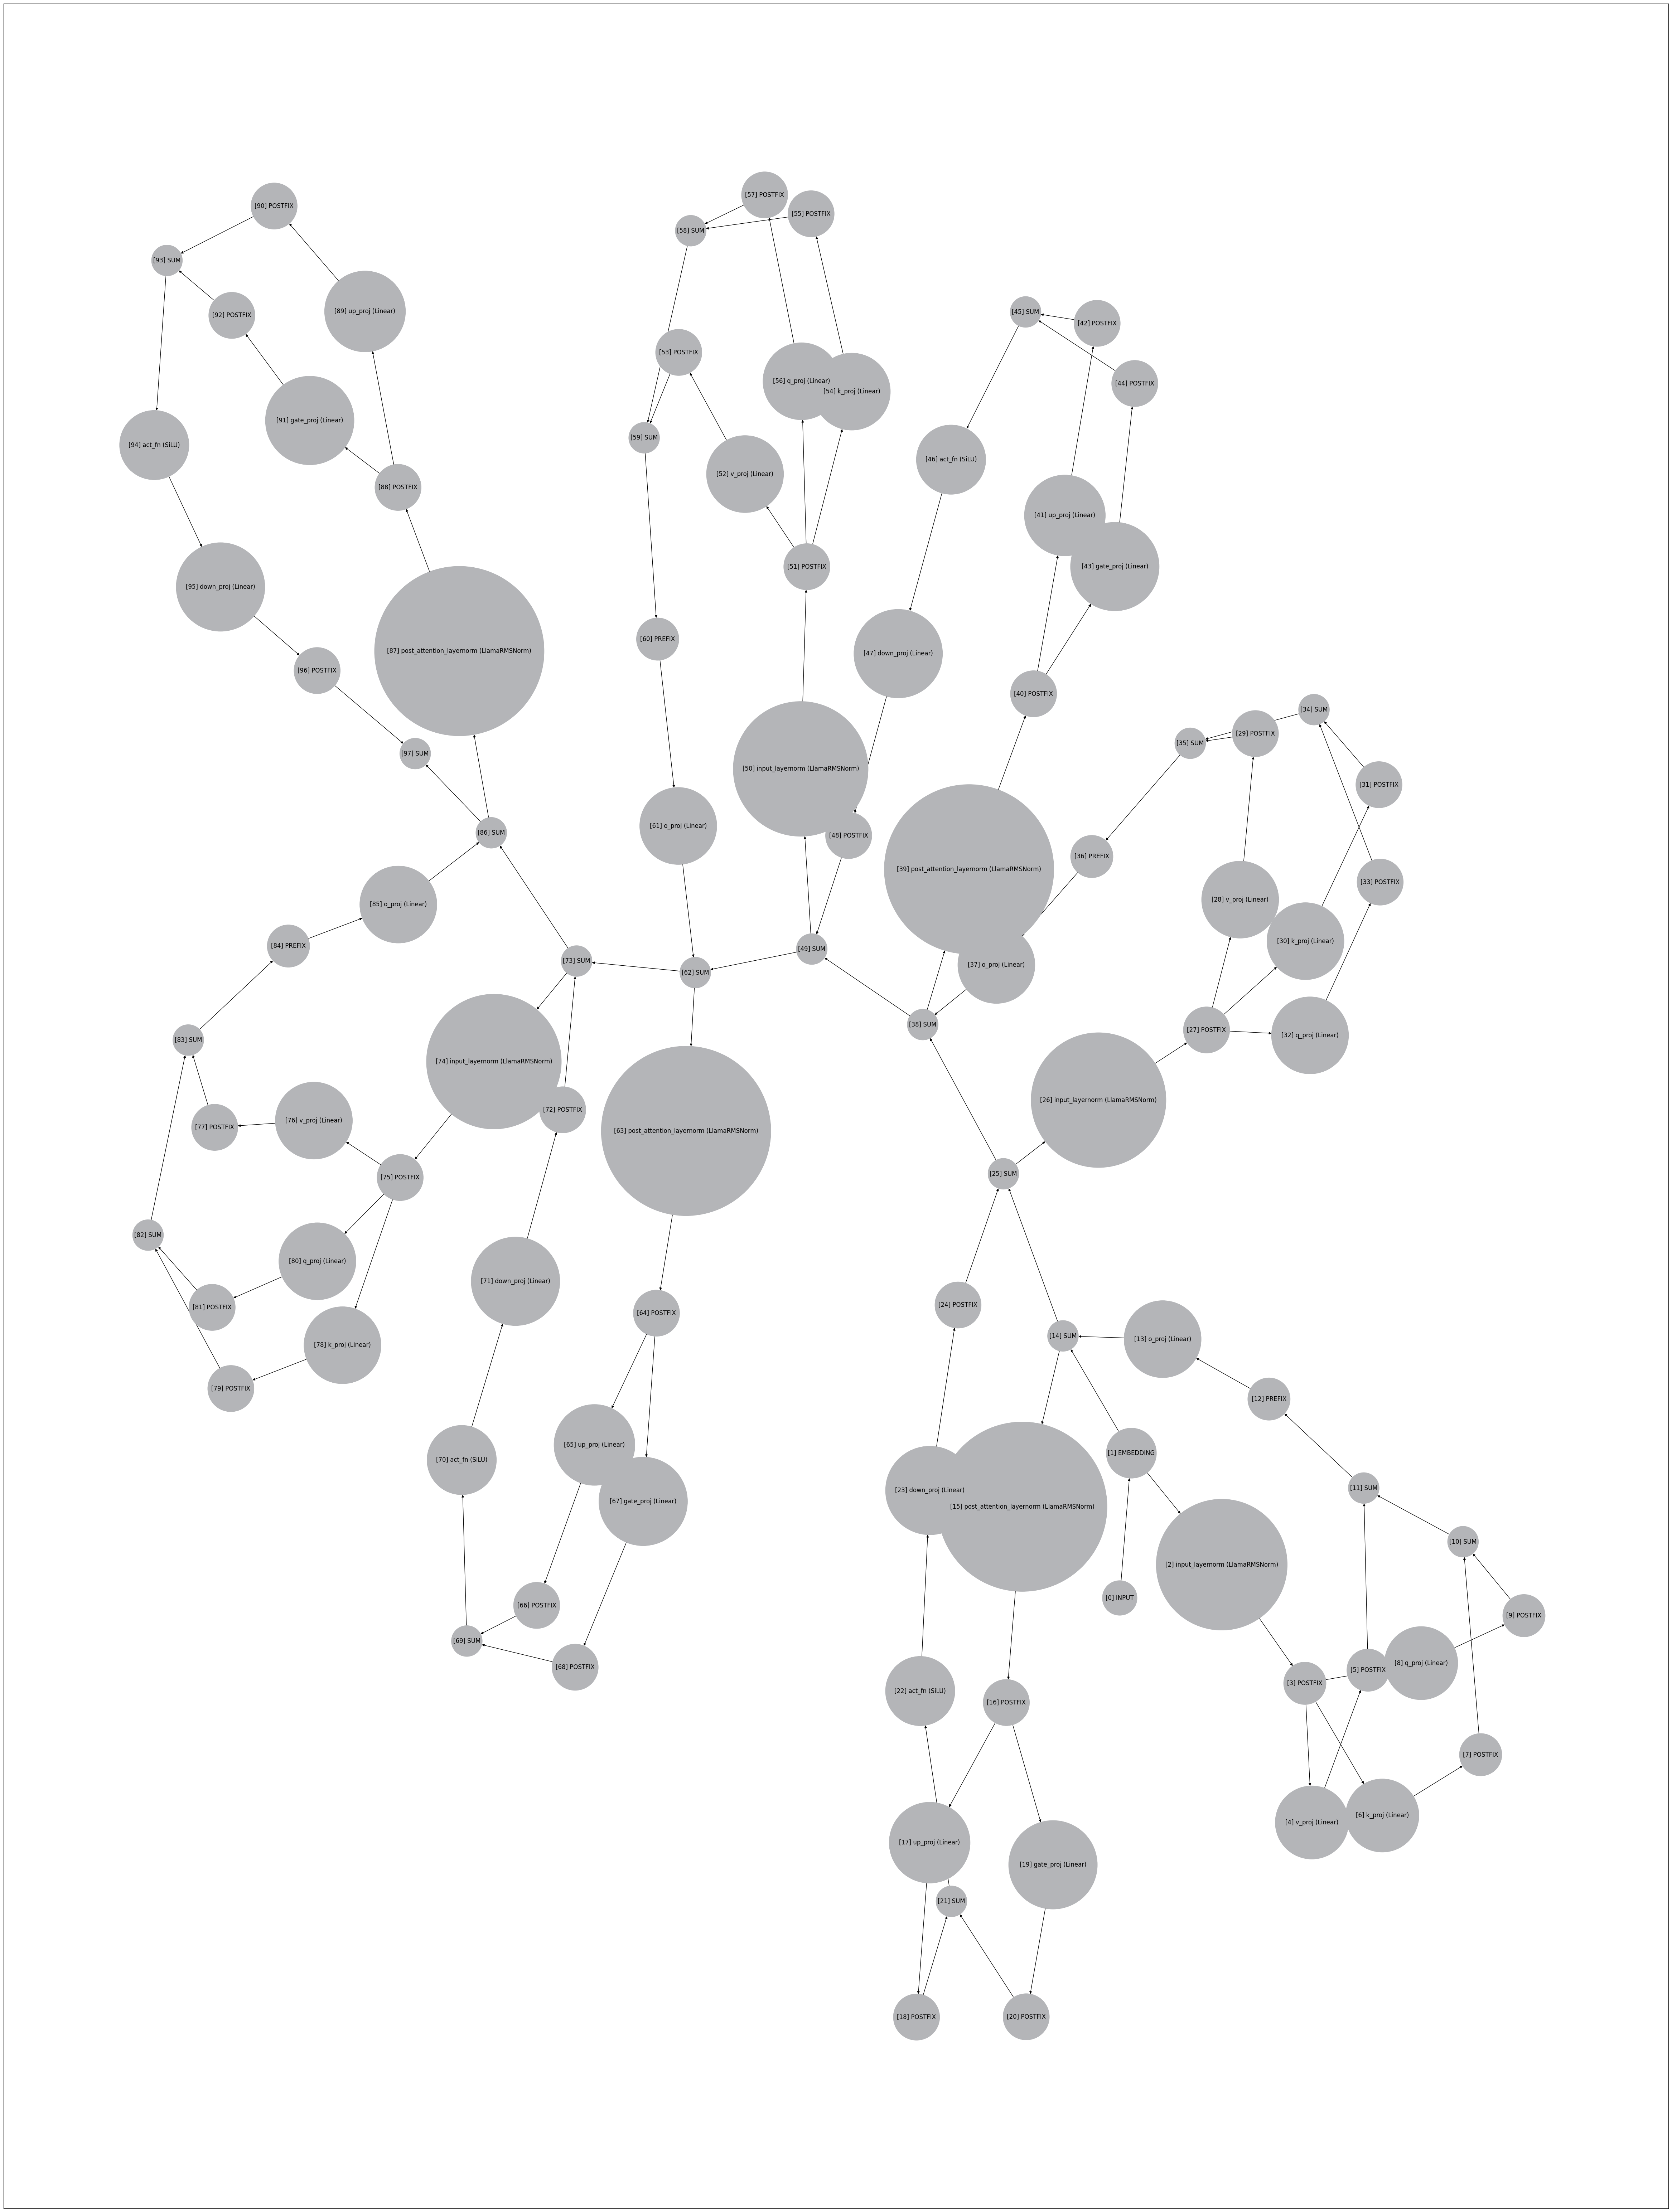

In [20]:
graph1.draw(figsize=(60, 80))

In [13]:
module_name_set = set()
modules = {}
for name, module in model.named_modules():
    if name == "layers":
        continue
    if "layers" in name and len(name.split(".")) == 2:
        #print("skipping ", name)
        continue
    if "layers" in name:
        second_dot_index = name.find('.', name.find('.') + 1)
        tmp_name = name[second_dot_index+1:]
        if len(tmp_name) > 0:
            module_name_set.add(tmp_name)
            modules[name] = module
    else:
        if name == "":
            continue
        module_name_set.add(name)
        modules[name] = module
print(module_name_set)


{'self_attn', 'mlp.gate_proj', 'embed_tokens', 'self_attn.o_proj', 'self_attn.q_proj', 'self_attn.k_proj', 'mlp.up_proj', 'input_layernorm', 'rotary_emb', 'norm', 'post_attention_layernorm', 'mlp', 'mlp.act_fn', 'self_attn.rotary_emb', 'mlp.down_proj', 'self_attn.v_proj'}


In [14]:
for name in sorted(list(module_name_set)):
    print(name)


embed_tokens
input_layernorm
mlp
mlp.act_fn
mlp.down_proj
mlp.gate_proj
mlp.up_proj
norm
post_attention_layernorm
rotary_emb
self_attn
self_attn.k_proj
self_attn.o_proj
self_attn.q_proj
self_attn.rotary_emb
self_attn.v_proj


In [53]:
modules["layers.1.self_attn.q_proj"]

Linear(in_features=576, out_features=576, bias=False)

In [48]:
len(modules)

393

In [50]:
modules[-8]

Linear(in_features=576, out_features=1536, bias=False)

In [21]:
# todo: figure out what we do for any output layers
# todo: check how to use rotary embeddings if there are any after embedding layer

In [ ]:
from torchviz import make_dot

def forward_hook(module, input, output):
    return output

activation = {}
model.layers[3].register_forward_hook(lambda m, i, o: activation.update({'layer3': o}))
input_ids = torch.randint(0, 100, (1, 10))
input_ids = input_ids.to(model.device)
output = model(input_ids)
#output.last_hidden_state
dot = make_dot(activation['layer3'][0], params=dict(model.named_parameters()))
dot.render("llama_graph", format="png", cleanup=True)

In [25]:
import torch

x = torch.randn(192, 10)
x = x.repeat(3,1)
print(x.shape)

torch.Size([576, 10])
